In [2]:
!pip install pycountry

You should consider upgrading via the '/Users/henrythierhoff/python_projects/jupyter_test/env/bin/python -m pip install --upgrade pip' command.


In [4]:
PATH = 'https://raw.githubusercontent.com/henrythier/covid-19/master'
OWID_PATH = 'https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv'

In [134]:
import pandas as pd
import numpy as np
import pycountry

#remove every row that does not correspond to a country
owid_data = pd.read_csv(OWID_PATH)
owid_data = owid_data[~owid_data['iso_code'].isnull()]
owid_data = owid_data[owid_data['iso_code'].apply(len) <= 3]

#replace iso letter code with numbers
country_dict = {}
country_list = list(map(lambda x: {x.alpha_3: x.numeric}, list(pycountry.countries)))
for c in country_list:
    country_dict.update(c)
country_list = list(country_dict.values())
owid_data = owid_data.replace({'iso_code': country_dict}).rename(columns={'iso_code': 'iso'}).set_index('iso')
owid_data

# make dict of country names to iso codes
name_to_iso_dict = {}
name_to_iso_dict_list = list(map(lambda x: {x.numeric: x.name}, list(pycountry.countries)))
for c in name_to_iso_dict_list:
    name_to_iso_dict.update(c)
name_list = list(name_to_iso_dict.values())

In [180]:
def choose_metric(comparison_metric, threshold_metric, threshold, owid_data):
    
    # remove unwanted columns and make dates column headers
    comparison_df = owid_data[['date', comparison_metric]].reset_index()
    comparison_df = comparison_df.pivot_table(index=['iso'], columns='date', values=comparison_metric)
    
    # init df for threshold metric
    threshold_df = owid_data[['date', threshold_metric]].reset_index()
    threshold_df = threshold_df.pivot_table(index=['iso'], columns='date', values=threshold_metric)
    
    # find first day where threshold was met for each country
    countries = threshold_df.index.values
    first_day = pd.DataFrame(columns=countries, index=['day_one'])
    num_of_days = len(threshold_df.columns)
    threshold_df.columns = np.arange(num_of_days)
    threshold_df = threshold_df.T
    
    for country in countries:
        try:
            day_one = threshold_df[country][threshold_df[country]>=threshold].index[0]
        except IndexError:
            day_one = num_of_days

        first_day.at['day_one', country] = day_one

    first_day = first_day.T
    first_day
    
    # set everything to threshold day
    set_to_zero = comparison_df
    for i in df.index:
        try:
            set_to_zero.loc[i] = comparison_df.loc[i].shift(-first_day['day_one'].loc[i])
        except KeyError:
            continue

    set_to_zero.columns = np.arange(len(comparison_df.columns))
    set_to_zero.dropna(axis='columns', how='all', inplace=True)
    return set_to_zero

In [108]:
choose_metric('total_deaths', 'total_cases', 100, owid_data)

,0,1,2,3,4,5,6,7,8,9,...,127,128,129,130,131,132,133,134,135,136
iso,,,,,,,,,,,,,,,,,,,,,
004,3.0,4.0,4.0,4.0,4.0,4.0,4.0,5.0,7.0,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
008,4.0,5.0,5.0,6.0,9.0,10.0,10.0,12.0,15.0,15.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
012,10.0,15.0,17.0,17.0,19.0,21.0,25.0,26.0,29.0,31.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
020,0.0,0.0,0.0,0.0,3.0,3.0,4.0,6.0,8.0,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
860,0.0,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
862,0.0,1.0,1.0,1.0,1.0,3.0,3.0,3.0,3.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
887,15.0,19.0,20.0,20.0,28.0,29.0,33.0,33.0,39.0,42.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [186]:
def get_peer_group(comp_country_name, peer_group_size):
    data = pd.read_csv(PATH + '/data/clean/aggregated.csv', index_col=[0], dtype={'iso':'string'}).dropna()
    data = data.loc[~data.index.duplicated()]
    data = (data-data.min())/(data.max()-data.min())
    comp_country = pycountry.countries.get(name=comp_country_name)
    comp_country.data = data.loc[comp_country.numeric]
    dist_string = 'Distance'
    data[dist_string] = 0.0
    columns = data.columns

    for index, row in data.iterrows():
        dist = row[columns[:-1]] - comp_country.data[columns[:-1]]
        dist = dist ** 2
        dist = dist.sum()
        data.at[index, dist_string] = dist

    peer_group = data.sort_values(dist_string).head(peer_group_size + 1)
    return peer_group

In [158]:
def visualize_results(results, comparison_metric, threshold_metric, threshold):
    variable_name = 'Days after ' + threshold_metric + ' >= ' + str(threshold)
    vis = results.reset_index().melt(id_vars=['Country'], var_name=variable_name, value_name=comparison_metric)
    sns.set_style("whitegrid")
    sns.lineplot(x=variable_name, y=comparison_metric, hue='Country', data=vis)
    plt.plot()

In [174]:
def compare_to_peers(comp_country_name, peer_group_size, comparison_metric, threshold_metric, threshold, owid_data):
    peer_group_index = get_peer_group(comp_country_name, peer_group_size).index
    metric_data = choose_metric(comparison_metric, threshold_metric, threshold, owid_data)
    result = metric_data.loc[peer_group_index].dropna(axis='columns', how='all')
    result_named = result.reset_index()
    result_named = result_named.replace({'iso': name_to_iso_dict})\
    .rename(columns={'iso': 'Country'}).set_index('Country')
    visualize_results(result_named, comparison_metric, threshold_metric, threshold)
    return result_named

In [189]:
import ipywidgets as widgets

country_drops = widgets.Combobox(options=name_list, value=name_list[0])
country_drops

Combobox(value='Aruba', options=('Aruba', 'Afghanistan', 'Angola', 'Anguilla', 'Åland Islands', 'Albania', 'An…

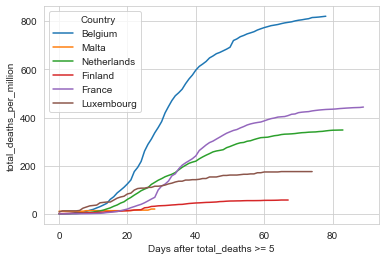

In [191]:
comp_country_name = country_drops.value
results = compare_to_peers(comp_country_name, 5, 'total_deaths_per_million', 'total_deaths', 5, owid_data)